In [1]:
import os
import sys
sys.path.append('/workspace/Documents')  ### remove this if not needed!
import numpy as np
import pandas as pd 
from tqdm import tqdm 
import random
from pathlib import Path
import nibabel as nb
import time

import argparse
from einops import rearrange
from natsort import natsorted
from madgrad import MADGRAD

import torch
import torch.backends.cudnn as cudnn
 
from original_SAM.utils.model_util import *
from original_SAM.segment_anything.model import build_model 
from original_SAM.utils.save_utils import *
from original_SAM.utils.config_util import Config
from original_SAM.utils.misc import NativeScalerWithGradNormCount as NativeScaler

# from original_SAM.train_engine import train_loop

import original_SAM.dataset.build_datasets as build_datasets
import original_SAM.functions_collection as ff
import original_SAM.get_args_parser as get_args_parser

main_path = '/mnt/camca_NAS/SAM_for_CMR/'  # replace with your own path

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15]


### define parameters for this experiment
The full setting can be find in ```get_args_parser.py```

In [6]:
# set experiment-specific parameters
trial_name = 'original_SAM_trial' 

output_dir = os.path.join(main_path, 'example_data_original_sam/models', trial_name)
ff.make_folder([os.path.join(main_path, 'example_data_original_sam/models'), output_dir])

pretrained_model = None # define your pre-trained model if any
start_epoch = 1
total_training_epochs = 100 # define total number of epochs

In [7]:
# define the original SAM model
original_sam = os.path.join( main_path, 'models/pretrained_sam/sam_vit_h_4b8939.pth') 

# define the number of segmented classes ## important
num_classes = 2

args = get_args_parser.get_args_parser(num_classes = num_classes,
                                       vit_type = "vit_h",
                                       pretrained_model = pretrained_model, 
                                       original_sam = original_sam, 
                                       start_epoch = start_epoch, 
                                       total_training_epochs = total_training_epochs)
args = args.parse_args([])

# some other settings
cfg = Config(args.config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = True

### define the training dataset

In [4]:
# define SAX training data
patient_list_file_sax = os.path.join(main_path,'example_data_original_sam/Patient_list/patient_list.xlsx')
patient_index_list = np.arange(0,1,1)
dataset_train_sax = build_datasets.build_dataset(
        args,
        patient_list_file = patient_list_file_sax, 
        index_list = patient_index_list, 
        shuffle = True, 
        augment = True)

index_array: [0]


### load pre-trained SAM model (freeze SAM modules)

In [10]:
# set model
model = build_model(args, device)

# # set freezed and trainable keys
# train_keys = []
# freezed_keys = []
        
# # load pretrained sam model vit_b
# if args.model_type.startswith("sam"):
#     if args.resume.endswith(".pth"):
#         with open(args.resume, "rb") as f:
#             state_dict = torch.load(f)
#         try:
#             model.load_state_dict(state_dict)
#         except:
#             if args.vit_type == "vit_h":
#                 new_state_dict = load_from(model, state_dict, args.img_size,  16, [7, 15, 23, 31])
               
#             model.load_state_dict(new_state_dict)
        
#         # # freeze original SAM layers
#         # freeze_list = [ "norm1", "attn" , "mlp", "norm2"]  
                
#         for n, value in model.named_parameters():
#             value.requires_grad = True
#             # if any(substring in n for substring in freeze_list):
#             #     freezed_keys.append(n)
#             #     value.requires_grad = False
#             # else:
#             #     train_keys.append(n)
#             #     value.requires_grad = True

# ## Select optimization method
# optimizer = MADGRAD(model.parameters(), lr=args.lr) # momentum=,weight_decay=,eps=)
        
# Continue training model
# if args.pretrained_model is not None:
#     if os.path.exists(args.pretrained_model):
#         print('loading pretrained model : ', args.pretrained_model)
#         args.resume = args.pretrained_model
#         finetune_checkpoint = torch.load(args.pretrained_model)
#         model.load_state_dict(finetune_checkpoint["model"])
#         optimizer.load_state_dict(finetune_checkpoint["optimizer"])
#         torch.cuda.empty_cache()
# else:
#     print('new training\n')

TypeError: build_sam_vit_h() got an unexpected keyword argument 'image_size'

### Training

In [7]:
training_log = []
model_save_folder = os.path.join(output_dir, 'models'); ff.make_folder([output_dir, model_save_folder])
log_save_folder = os.path.join(output_dir, 'logs'); ff.make_folder([log_save_folder])

for epoch in range(args.start_epoch, args.start_epoch + args.total_training_epochs):
        print('training epoch:', epoch)

        if epoch % args.lr_update_every_N_epoch == 0:
            optimizer.param_groups[0]["lr"] = optimizer.param_groups[0]["lr"] * args.lr_decay_gamma
        print('learning rate now:', optimizer.param_groups[0]["lr"])
        
        loss_scaler = NativeScaler()
            
        train_results = train_loop(
                model = model,
                data_loader_train  = data_loader_train,
                optimizer = optimizer,
                epoch = epoch, 
                loss_scaler = loss_scaler,
                args = args,
                inputtype = cfg.data.input_type)   
        
        loss, lossCE, lossDICE, sax_loss, sax_lossCE, sax_lossDICE, lax_loss, lax_lossCE, lax_lossDICE = train_results       
            
        print('in epoch: ', epoch, ' training average_loss: ', loss, ' average_lossCE: ', lossCE, ' average_lossDICE: ', lossDICE, ' sax_loss: ', sax_loss, ' sax_lossCE: ', sax_lossCE, ' sax_lossDICE: ', sax_lossDICE, ' lax_loss: ', lax_loss, ' lax_lossCE: ', lax_lossCE, ' lax_lossDICE: ', lax_lossDICE)
    
        # on_epoch_end:
        for k in range(len(dataset_train)):
            dataset_train[k].on_epoch_end()
    
        if  epoch % args.save_model_file_every_N_epoch == 0 or (epoch + 1) == args.start_epoch + args.total_training_epochs:
            checkpoint_path = os.path.join(model_save_folder,  'model-%s.pth' % epoch)
            to_save = {
                        'model': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'epoch': epoch,
                        'scaler': loss_scaler.state_dict(),
                        'args': args,}
            torch.save(to_save, checkpoint_path)

        training_log.append([epoch, optimizer.param_groups[0]["lr"], train_results[0], train_results[1], train_results[2], train_results[3], train_results[4], train_results[5], train_results[6], train_results[7], train_results[8]])
        df = pd.DataFrame(training_log, columns=['epoch', 'lr','average_loss', 'average_lossCE', 'average_lossDICE', 'sax_loss', 'sax_lossCE', 'sax_lossDICE', 'lax_loss', 'lax_lossCE', 'lax_lossDICE'])
        df.to_excel(os.path.join(log_save_folder, 'training_log.xlsx'), index=False)

training epoch: 1
learning rate now: 9.025e-05
in train loop we have turn_zero_seg_slice_into:  10
in training current slice type:  sax


/workspace/Documents/cineCMR_SAM/utils/misc.py:252: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self._scaler = torch.cuda.amp.GradScaler()
/workspace/Documents/cineCMR_SAM/train_engine.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch: [1]  [ 0/11]  eta: 0:00:33  lr: 0.000090  loss1: 0.0613 (0.0613)  time: 3.0093  data: 2.0194  max mem: 23355
Epoch: [1]  [10/11]  eta: 0:00:00  lr: 0.000090  loss1: 0.0553 (0.0561)  time: 0.5526  data: 0.3483  max mem: 23355
Epoch: [1] Total time: 0:00:06 (0.5527 s / it)
in training current slice type:  lax
Epoch: [1]  [0/1]  eta: 0:00:00  lr: 0.000090  loss1: 0.0553 (0.0673)  time: 0.2644  data: 0.1368  max mem: 23355
Epoch: [1] Total time: 0:00:00 (0.2653 s / it)
in epoch:  1  training average_loss:  0.06731000170111656  average_lossCE:  0.032660245119283594  average_lossDICE:  0.06929951409498851  sax_loss:  0.056121711026538505  sax_lossCE:  0.02998106706548821  sax_lossDICE:  0.052281287583437835  lax_loss:  0.19038119912147522  lax_lossCE:  0.06213120371103287  lax_lossDICE:  0.2565000057220459
now run on_epoch_end function
now run on_epoch_end function


index_array: [4, 1, 7, 3, 2, 5, 0, 9, 8, 6]
current index: 0 file index: 4 file name: /mnt/camca_NAS/SAM_for_CMR/example_data_original_sam/data/ID_0002/img_slice04.nii.gz


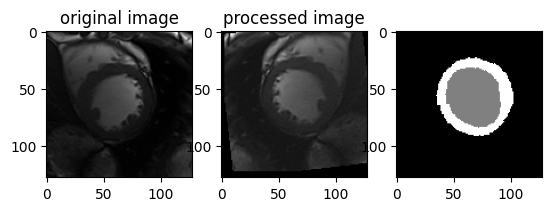

In [6]:
file = os.path.join(main_path,'example_data_original_sam/Patient_list/patient_list.xlsx')
patient_id_list, img_file_list, seg_file_list, slice_index_list = from_excel_file(file, index_list = np.arange(0,10,1))

dataset_train = Dataset_CMR(
        patient_list_spreadsheet_file = file,

        image_file_list = img_file_list,
        seg_file_list = seg_file_list,

        return_arrays_or_dictionary = 'dictionary', # "arrays" or "dictionary"
        center_crop_according_to_which_class = 1,

        image_shape = [128,128], # [x,y], channel =  tf always 15 
        shuffle = True,
        image_normalization = True,
        augment = True,
        augment_frequency = 0.9, # how often do we do augmentation
        )

# iterate this generator
for idx, sample in enumerate(dataset_train):
    
    original_img = sample['original_image'].squeeze().numpy()
    img= sample['image'].squeeze().numpy()
    seg = sample['mask'].squeeze().numpy()

    # plot original image, processed image and seg
    import matplotlib.pyplot as plt
    plt.subplot(1,3,1)
    plt.imshow(original_img, cmap='gray')
    plt.title('original image')
    plt.subplot(1,3,2)
    plt.imshow(img, cmap='gray')
    plt.title('processed image')
    plt.subplot(1,3,3)
    plt.imshow(seg, cmap='gray')



    if idx == 0:  # 假设只看前三个
        break